In [1]:
import sys
import os
path = os.path.abspath("../")
sys.path.append(path)
print(path)

/home/jovyan


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader, TensorDataset, Sampler, random_split, Dataset, Subset
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import random

from collections import defaultdict, Counter
from line_profiler import profile
from scipy.linalg import orthogonal_procrustes


import src.helpers.MetricUtilities as metrics
import src.data_processing.ImageProducts as ImageProducts
from functools import partial

from mtree.mtree import MTree
import mtree.mtree as mtree

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

%reload_ext autoreload

%autoreload 2

cpu


In [3]:
import sys
import os
path = os.path.abspath("../")
sys.path.append(path)

import torch
from torch.utils.data import Dataset, Subset
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import random

from line_profiler import profile

import src.helpers.MetricUtilities as metrics


from mtree.mtree import MTree
import mtree.mtree as mtree

import glob
from PIL import Image

import time


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# TODO: Put these in a separate file for MTreeUtils...
def getKNearestNeighbours(tree, point, k):
    l = tree.search(point, k)
    imgs = list(l)
    return imgs

def getMTree(data, k, promote=mtree.M_LB_DIST_confirmed, partition=mtree.generalized_hyperplane, d=metrics.distance):
    # k: desired number of nearest neighbours
    tree = MTree(d, max_node_size=k, promote=promote, partition=partition)
    tree.add_all(data)
    return tree

def getMTreeFFT(data, k):
    # k: desired number of nearest neighbours
    tree = MTree(metrics.dist_fft, max_node_size=k)
    tree.add_all(data)
    return tree

def getMTreeFFTNumba(data, k, promote=mtree.M_LB_DIST_confirmed, partition=mtree.generalized_hyperplane):
    # k: desired number of nearest neighbours
    tree = MTree(metrics.dist_fft_numba, max_node_size=k, promote=promote, partition=partition)
    tree.add_all(data)
    return tree

class CustomDataset(Dataset):
    def __init__(self, transform=None):
        self.transform = transform

        self.imgs_path = "../data/imdb_wiki/"
        file_list = glob.glob(self.imgs_path + "*")
        self.images = []
        for class_path in file_list:
            for dir_path in glob.glob(class_path + "/*"):
                for img_path in glob.glob(dir_path + "/*.jpg"):
                    self.images.append(img_path)

    # Defining the length of the dataset
    def __len__(self):
        return len(self.images)

    # Defining the method to get an item from the dataset
    def __getitem__(self, index):
        image_path = self.images[index]
        image = Image.open(image_path)
        image = transforms.functional.to_grayscale(image)

        # Applying the transform
        if self.transform:
            image = self.transform(image)
        
        return image.squeeze().to('cpu').numpy()



class CustomDatasetMStar(Dataset):
    def __init__(self, transform=None):
        self.transform = transform

        self.imgs_path = "../data/mstar/Padded_imgs/"
        file_list = glob.glob(self.imgs_path + "*")
        self.data = []
        for class_path in file_list:
            class_name = class_path.split("/")[-1]
            for img_path in glob.glob(class_path + "/*.JPG"):
                self.data.append([img_path, class_name])
        #print(self.data)
        self.class_map = {"2S1" : 0, "BRDM_2": 1, "BTR_60": 2, "D7": 3, "SLICY": 4, "T62": 5, "ZIL131": 6, "ZSU_23_4": 7}

    # Defining the length of the dataset
    def __len__(self):
        return len(self.data)

    # Defining the method to get an item from the dataset
    def __getitem__(self, index):
        data_path = self.data[index]
        image = Image.open(data_path[0])
        image = transforms.functional.to_grayscale(image)
        class_id = self.class_map[data_path[1]]
        # Applying the transform
        if self.transform:
            image = self.transform(image)
        
        return image.squeeze().to('cpu').numpy(), class_id

def get_data(size):
    transform = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
    ])
    return CustomDataset(transform)

def get_data_MStar(size):
    transform = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
    ])
    return CustomDatasetMStar(transform)

def mtree_ncc_query_sample_size(max_node_size=12, image_size=32, k=7, runs=2, sample_sizes=[1]):
    total_time_ncc = 0
    total_time_mtree = 0
    avg_times_ncc = []
    avg_times_mtree = []

    data = get_data_MStar(image_size)

    print(f"Average runtime of querying mtree and ncc for {k} NN over {runs} runs with image size {image_size} and max node size {max_node_size} and variable sample size")
    for i in range(len(sample_sizes)):
        print(f"NOW TRYING sample size: {sample_sizes[i]}")
        total_time_ncc = 0
        total_time_mtree = 0

        sample_indices = random.sample(range(len(data)), sample_sizes[i])
        sampled_test_data = Subset(data, sample_indices)

        testSample = [item[0] for item in sampled_test_data]
        

        tree = getMTree(testSample, max_node_size)

        # trans = transforms.Compose([transforms.Resize(img_sizes[i])])
        # t_MNIST_data = trans(MNIST_data)

        # for img in MNIST_data:
        #     img = trans(img)

        for _ in range(runs):
            index1 = np.random.randint(len(data))
            #input1=input_dataset[index1][0].squeeze().to('cpu')
            unseen_image = data[index1][0]

            start_time = time.time()
            arr = []
            for j in range(len(testSample)):
                result = ImageProducts.ncc_scaled(testSample[j], unseen_image)
                arr.append(result)
            
            unseen_img_arr = np.array(arr)
            #print(unseen_img_arr)
            imgProd_max_index = np.argpartition(unseen_img_arr, -(k+1))[-(k+1):]
            end_time = time.time()

            total_time_ncc += end_time - start_time

            start_time = time.time()
            imgs = getKNearestNeighbours(tree, unseen_image, k+1)
            end_time = time.time()
            total_time_mtree += end_time - start_time

        avg_ncc = total_time_ncc / runs
        avg_mtree = total_time_mtree / runs
        avg_times_ncc.append(avg_ncc)
        avg_times_mtree.append(avg_mtree)

        # with open("test_mtree_query_sample_sizes_avg_times_ncc_.txt", "w") as file:
        #     file.write(f"avg times: {str(avg_times_ncc)}")
        
        # with open("test_mtree_query_sample_sizes_avg_times_mtree_.txt", "w") as file:
        #     file.write(f"avg times: {str(avg_times_mtree)}")

        print(f"Average runtime of ncc search: {avg_ncc:.6f} seconds")
        print(f"Average runtime of mtree search: {avg_mtree:.6f} seconds")
    # plot_data_mtree_ncc(x_axis="Sample size", title=f"Average runtime of finding {k} neighbours with image size {image_size} against sample sizes", filename="test_mtree_query_sample_sizes.png", 
    #                     varied_arr=sample_sizes, data1=avg_times_ncc, data2=avg_times_mtree, max_node_size=max_node_size)


def mtree_init_sample_size(max_node_size=12, image_size=32, k=7, runs=2, sample_sizes=[1]):
    total_time_mtree_init = 0
    avg_times_mtree_init = []

    data = get_data_MStar(image_size)

    print(f"Average runtime of initialising mtree over {runs} runs with max node size {max_node_size} and image size {image_size} and variable sample sizes")

    for i in range(len(sample_sizes)):
        print(f"NOW TRYING sample size: {sample_sizes[i]}")
        total_time_mtree_init = 0

        sample_indices = random.sample(range(len(data)), sample_sizes[i])
        sampled_test_data = Subset(data, sample_indices)

        testSample = [item[0] for item in sampled_test_data]
        #sampled_test_data[:,0]

        for _ in range(runs):
            start_time = time.time()
            tree = getMTree(testSample, max_node_size)
            end_time = time.time()
            total_time_mtree_init += end_time - start_time
            print(f"Finished one run of mtree init...")

        
        avg_mtree_init = total_time_mtree_init / runs
        avg_times_mtree_init.append(avg_mtree_init)

        
        # with open("test_mtree_init_sample_sizes_avg_times_mtree_init.txt", "w") as file:
        #     file.write(f"avg times: {str(avg_times_mtree_init)}")

        print(f"Average runtime of mtree init: {avg_mtree_init:.6f} seconds")
    
    # plot_data_mtree_init(x_axis="Sample size", title=f"Average runtime of initialising mtree with image size {image_size}, max node size {max_node_size} against sample sizes", filename="test_mtree_init_sample_sizes.png", 
    #                     varied_arr=sample_sizes, data=avg_times_mtree_init, max_node_size=max_node_size)

In [172]:
# 9466 samples
# note MStar is 368 by 368...

mtree_ncc_query_sample_size(max_node_size=15, image_size=368, k=7, runs=10, sample_sizes=[10, 100, 1000, 2000])

Average runtime of querying mtree and ncc for 7 NN over 10 runs with image size 368 and max node size 15 and variable sample size
NOW TRYING sample size: 10


NameError: name 'ImageProducts' is not defined

In [ ]:
import json

with open("../data/SARDet_100k/SARDet_100K/Annotations/val.json") as val_annotations:
    mappings = json.load(val_annotations)

print(mappings["images"][0])
print(len(mappings["images"]))

{'file_name': '0012296.jpg', 'height': 512, 'width': 512, 'id': 0}
10492


In [ ]:
'''
@inproceedings{li2024sardet100k,
	title={SARDet-100K: Towards Open-Source Benchmark and ToolKit for Large-Scale SAR Object Detection}, 
	author={Yuxuan Li and Xiang Li and Weijie Li and Qibin Hou and Li Liu and Ming-Ming Cheng and Jian Yang},
	year={2024},
	booktitle={The Thirty-eighth Annual Conference on Neural Information Processing Systems (NeurIPS)},
}

@article{zhang2025rsar,
  title={RSAR: Restricted State Angle Resolver and Rotated SAR Benchmark},
  author={Zhang, Xin and Yang, Xue and Li, Yuxuan and Yang, Jian and Cheng, Ming-Ming and Li, Xiang},
  journal={Proceedings of the IEEE/CVF conference on computer vision and pattern recognition},
  year={2025}
}

@article{dai2024denodet,
	title={DenoDet: Attention as Deformable Multi-Subspace Feature Denoising for Target Detection in SAR Images},
	author={Dai, Yimian and Zou, Minrui and Li, Yuxuan and Li, Xiang and Ni, Kang and Yang, Jian},
	journal={arXiv preprint arXiv:2406.02833},
	year={2024}
}
'''
import json
# TODO look at train/val/test.json format and extract out the category id and the id to class mapping at the v end.


class CustomDatasetSARDet_100k(Dataset):
    def __init__(self, transform=None):
        self.transform = transform
        self.data = []
        
        with open("../data/SARDet_100k/SARDet_100K/Annotations/test.json") as annotations:
            test_mapping = json.load(annotations)
        with open("../data/SARDet_100k/SARDet_100K/Annotations/train.json") as annotations:
            train_mapping = json.load(annotations)
        with open("../data/SARDet_100k/SARDet_100K/Annotations/val.json") as annotations:
            val_mapping = json.load(annotations)
        
        self.imgs_path = "../data/SARDet_100k/SARDet_100K/JPEGImages/"

        test_path = self.imgs_path + "test/"
        train_path = self.imgs_path + "train/"
        val_path = self.imgs_path + "val/"

        for i in range(len(test_mapping["images"])):
            img_path = test_path + test_mapping["images"][i]["file_name"]
            cat_id = test_mapping["annotations"][i]["category_id"]
            cat_name = test_mapping["categories"][int(cat_id)]["name"]
            self.data.append([img_path, cat_name])

        for i in range(len(train_mapping["images"])):
            img_path = train_path + train_mapping["images"][i]["file_name"]
            cat_id = train_mapping["annotations"][i]["category_id"]
            cat_name = train_mapping["categories"][int(cat_id)]["name"]
            self.data.append([img_path, cat_name])
        
        for i in range(len(val_mapping["images"])):
            img_path = val_path + val_mapping["images"][i]["file_name"]
            cat_id = val_mapping["annotations"][i]["category_id"]
            cat_name = val_mapping["categories"][int(cat_id)]["name"]
            self.data.append([img_path, cat_name])

        # file_list = glob.glob(self.imgs_path + "*")
        # self.data = []

        # # with open("../data/SARDet_100k/SARDet_100K/mapping.json") as annotations:
        # #     mappings = json.load(annotations)

        # for dir_path in file_list:
        #     for img_path in glob.glob(dir_path + "/*.png"):
        #         # self.data.append([img_path, mappings[img_path.split("/")[-1]]])
        #         self.data.append([img_path, "yippee"])
        #     for img_path in glob.glob(dir_path + "/*.jpg"):
        #         # self.data.append([img_path, mappings[img_path.split("/")[-1]]])
        #         self.data.append([img_path, "yippee"])
        

    # Defining the length of the dataset
    def __len__(self):
        return len(self.data)

    # Defining the method to get an item from the dataset
    def __getitem__(self, index):
        data_path = self.data[index]
        image = Image.open(data_path[0])
        image = transforms.functional.to_grayscale(image)
        # class_id = self.class_map[data_path[1]]
        class_id = data_path[1]
        # Applying the transform
        if self.transform:
            image = self.transform(image)
        
        return image.squeeze().to('cpu').numpy(), class_id

def get_data_SARDet_100k(size):
    transform = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
    ])
    return CustomDatasetSARDet_100k(transform)


In [185]:
import xml.etree.ElementTree as ET

tree = ET.parse('/home/jovyan/data/ATRNet-STAR/EOC_azimuth/test/Buick_Excelle_GT/KU_HH_15_80_325790.xml')
root = tree.getroot()

print("Root tag:", root.tag)


img_path = root.find('filename').text
broad_class = root.find('object').find('class').text
subclass = root.find('object').find('subclass').text
subclass_type = root.find('object').find('type').text.split("_")[-1]

print(img_path)
print(broad_class)
print(subclass)
print(subclass_type)

Root tag: annotation
KU_HH_15_80_325790.tif
Car
Medium_Car
GT


In [ ]:
'''
misc{liu2025atrnet,
    title={{ATRNet-STAR}: A Large Dataset and Benchmark Towards Remote Sensing Object Recognition in the Wild}, 
    author={Yongxiang Liu and Weijie Li and Li Liu and Jie Zhou and Bowen Peng and Yafei Song and Xuying Xiong and Wei Yang and Tianpeng Liu and Zhen Liu and Xiang Li},
    year={2025},
    eprint={2501.13354},
    archivePrefix={arXiv},
    primaryClass={cs.CV},
    url={https://arxiv.org/abs/2501.13354},
}

@ARTICLE{li2025saratr,
  author={Li, Weijie and Yang, Wei and Hou, Yuenan and Liu, Li and Liu, Yongxiang and Li, Xiang},
  journal={IEEE Transactions on Image Processing}, 
  title={SARATR-X: Toward Building a Foundation Model for SAR Target Recognition}, 
  year={2025},
  volume={34},
  number={},
  pages={869-884},
  doi={10.1109/TIP.2025.3531988}}

@ARTICLE{li2024predicting,
  title = {Predicting gradient is better: Exploring self-supervised learning for SAR ATR with a joint-embedding predictive architecture},
  journal = {ISPRS Journal of Photogrammetry and Remote Sensing},
  volume = {218},
  pages = {326-338},
  year = {2024},
  issn = {0924-2716},
  doi = {https://doi.org/10.1016/j.isprsjprs.2024.09.013},
  url = {https://www.sciencedirect.com/science/article/pii/S0924271624003514},
  author = {Li, Weijie and Yang, Wei and Liu, Tianpeng and Hou, Yuenan and Li, Yuxuan and Liu, Zhen and Liu, Yongxiang and Liu, Li}}

Downloads last month
167
System
'''
import xml.etree.ElementTree as ET



class CustomDatasetATRNetSTAR(Dataset):
    def __init__(self, transform=None):
        self.transform = transform
        self.data = []
        # Check if I can test the azimuths.... if not j try smt else idk
        self.imgs_path = "../data/ATRNet-STAR/EOC_azimuth/"
        file_list = glob.glob(self.imgs_path + "*")

        for dir_path in file_list:
            for cat in glob.glob(dir_path + "/"):
                for xml_file_path in glob.glob(cat + "/*.xml"):
                    tree = ET.parse(xml_file_path)
                    root = tree.getroot()
                    img_path = root.find('filename').text
                    broad_class = root.find('object').find('class').text
                    subclass = root.find('object').find('subclass').text
                    subclass_type = root.find('object').find('type').text.split("_")[-1]
                    self.data.append([img_path, broad_class, subclass, subclass_type])
    

        # file_list = glob.glob(self.imgs_path + "*")
        # self.data = []

        # # with open("../data/SARDet_100k/SARDet_100K/mapping.json") as annotations:
        # #     mappings = json.load(annotations)

        # for dir_path in file_list:
        #     for img_path in glob.glob(dir_path + "/*.png"):
        #         # self.data.append([img_path, mappings[img_path.split("/")[-1]]])
        #         self.data.append([img_path, "yippee"])
        #     for img_path in glob.glob(dir_path + "/*.jpg"):
        #         # self.data.append([img_path, mappings[img_path.split("/")[-1]]])
        #         self.data.append([img_path, "yippee"])
        

    # Defining the length of the dataset
    def __len__(self):
        return len(self.data)

    # Defining the method to get an item from the dataset
    def __getitem__(self, index):
        data_path = self.data[index]
        image = Image.open(data_path[0])
        image = transforms.functional.to_grayscale(image)
        # class_id = self.class_map[data_path[1]]
        broad_class = data_path[1]
        subclass = data_path[2]
        subclass_type = data_path[3]
        # Applying the transform
        if self.transform:
            image = self.transform(image)
        
        return image.squeeze().to('cpu').numpy(), broad_class, subclass, subclass_type



def get_data_ATRNetSTAR(size):
    transform = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
    ])
    return CustomDatasetATRNetSTAR(transform)


In [44]:
data = get_data_SARDet_100k(300)
print(len(data))
sample_indices = random.sample(range(len(data)), 100)
sampled_test_data = Subset(data, sample_indices)

testSample = [item[0] for item in sampled_test_data]
classes = [item[1] for item in sampled_test_data]


116598


aircraft


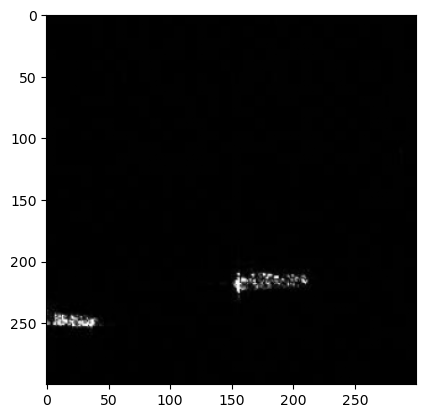

In [47]:
index1 = np.random.randint(len(testSample))
#index2 = np.random.randint(len(testSample))
#input2=input_dataset[index2][0].squeeze().to('cpu')
print(classes[index1])
plt.imshow(testSample[index1], cmap='grey')
plt.show()


In [7]:

k=7
data = get_data_MStar(368)
print(len(data))
sample_indices = random.sample(range(len(data)), 100)
sampled_test_data = Subset(data, sample_indices)

testSample = [item[0] for item in sampled_test_data]
classes = [item[1] for item in sampled_test_data]

# class_map = {"2S1" : 0, "BRDM_2": 1, "BTR_60": 2, "D7": 3, "SLICY": 4, "T62": 5, "ZIL131": 6, "ZSU_23_4": 7}

tree = getMTree(testSample, 12)

index1 = random.choice(sample_indices)
#input1=input_dataset[index1][0].squeeze().to('cpu')
unseen_image = data[index1][0]
unseen_image_class = data[index1][1]

arr = []
for j in range(len(testSample)):
    result = ImageProducts.ncc_scaled(testSample[j], unseen_image)
    arr.append(result)

unseen_img_arr = np.array(arr)
#print(unseen_img_arr)
imgProd_max_index = np.argpartition(unseen_img_arr, -(k+1))[-(k+1):]

num_same_class = 0

print(f"Unseen img class: {unseen_image_class}")
for i in imgProd_max_index:
    img_class = classes[i]
    print(f"Index {i}, Class {img_class}")
    if (img_class == unseen_image_class):
        num_same_class += 1

print(num_same_class)


imgs = getKNearestNeighbours(tree, unseen_image, k+1)


def imgs_to_indices(img_arr, testSample):
    ind_arr = []
    for img in img_arr:
        for i in range(len(testSample)):
            if (metrics.distance(img, testSample[i]) < 0.00001):
                ind_arr.append(i)
                break
    
    return ind_arr

ind_arr = imgs_to_indices(imgs, testSample)
print(ind_arr)
print(imgProd_max_index)


9466


KeyboardInterrupt: 

In [147]:
import numpy as np
import cv2

def ncc(mainImg, tempImg) -> float:
    """
    :param mainImg: Main image to be scanned
    :param tempImg: Template image to be scanned over the main
    :return: Max value of the ncc

    Applies NCC of the template image over the main image and returns the max value obtained.
    When the template image kernel exceeds the bounds, wraps to the other side of the main image
    """
    if np.count_nonzero(mainImg) == 0:
        if np.count_nonzero(tempImg) == 0:
            return 1
        return 0

    mainImg = np.pad(mainImg, max(len(mainImg), len(mainImg[0])),
                     'wrap')  # Padding the main image with wrapped values to simulate wrapping

    mainImg = np.asarray(mainImg, np.single)  # Setting data types of array
    tempImg = np.asarray(tempImg, np.single)

    corr = cv2.matchTemplate(mainImg, tempImg, cv2.TM_CCORR_NORMED)

    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(corr)

    return max_val

def ncc_scaled(mainImg, tempImg) -> float:
    """
    :param mainImg: Main image to be scanned
    :param tempImg: Template image to be scanned over the main
    :return: Max value of the ncc, with scaled bounds of [-1,1]
    """
    return ncc(mainImg, tempImg) * 2 - 1


class CustomDatasetMStar(Dataset):
    def __init__(self, transform=None):
        self.transform = transform

        self.imgs_path = "../data/mstar/Padded_imgs/"
        file_list = glob.glob(self.imgs_path + "*")
        self.data = []
        for class_path in file_list:
            class_name = class_path.split("/")[-1]
            for img_path in glob.glob(class_path + "/*.JPG"):
                self.data.append([img_path, class_name])
        #print(self.data)
        self.class_map = {"2S1" : 0, "BRDM_2": 1, "BTR_60": 2, "D7": 3, "SLICY": 4, "T62": 5, "ZIL131": 6, "ZSU_23_4": 7}

    # Defining the length of the dataset
    def __len__(self):
        return len(self.data)

    # Defining the method to get an item from the dataset
    def __getitem__(self, index):
        data_path = self.data[index]
        image = Image.open(data_path[0])
        image = transforms.functional.to_grayscale(image)
        class_id = self.class_map[data_path[1]]
        # Applying the transform
        if self.transform:
            image = self.transform(image)
        
        return image.squeeze().to('cpu').numpy(), class_id

k=7
data = get_data_MStar(16)
print(len(data))
sample_indices = random.sample(range(len(data)), 100)
sampled_test_data = Subset(data, sample_indices)

testSample = [item[0] for item in sampled_test_data]
classes = [item[1] for item in sampled_test_data]

# class_map = {"2S1" : 0, "BRDM_2": 1, "BTR_60": 2, "D7": 3, "SLICY": 4, "T62": 5, "ZIL131": 6, "ZSU_23_4": 7}

tree = getMTreeFFTNumba(testSample, 12)
tree_mst = getMTreeFFTNumba(testSample, 12, promote=mtree.MST_promotion, partition=mtree.MST_partition)

index1 = random.choice(sample_indices)
#input1=input_dataset[index1][0].squeeze().to('cpu')
unseen_image = data[index1][0]
unseen_image_class = data[index1][1]

arr = []
for j in range(len(testSample)):
    result = ncc_scaled(testSample[j], unseen_image)
    arr.append(result)

unseen_img_arr = np.array(arr)
#print(unseen_img_arr)
imgProd_max_index = np.argpartition(unseen_img_arr, -(k+1))[-(k+1):]

num_same_class = 0

print(f"Unseen img class: {unseen_image_class}")
for i in imgProd_max_index:
    img_class = classes[i]
    print(f"Index {i}, Class {img_class}")
    if (img_class == unseen_image_class):
        num_same_class += 1

print(num_same_class)


imgs = getKNearestNeighbours(tree, unseen_image, k+1)
imgs_mst = getKNearestNeighbours(tree_mst, unseen_image, k+1)

def imgs_to_indices(img_arr, testSample):
    ind_arr = []
    for img in img_arr:
        for i in range(len(testSample)):
            if (metrics.dist_fft_numba(img, testSample[i]) < 0.0000001):
                ind_arr.append(i)
                break
    
    return ind_arr

ind_arr = imgs_to_indices(imgs, testSample)
ind_arr_mst = imgs_to_indices(imgs_mst, testSample)
print(ind_arr_mst)
print(ind_arr)
print(imgProd_max_index)


9466
Unseen img class: 2
Index 2, Class 1
Index 56, Class 6
Index 95, Class 2
Index 57, Class 0
Index 46, Class 2
Index 69, Class 0
Index 93, Class 7
Index 58, Class 2
3
[58, 93, 69, 46, 57, 95, 56, 2]
[58, 93, 69, 46, 57, 95, 56, 2]
[ 2 56 95 57 46 69 93 58]


In [150]:
import scipy.fft
import math

def ncc(mainImg, tempImg) -> float:
    """
    :param mainImg: Main image to be scanned
    :param tempImg: Template image to be scanned over the main
    :return: Max value of the ncc

    Applies NCC of the template image over the main image and returns the max value obtained.
    When the template image kernel exceeds the bounds, wraps to the other side of the main image
    """
    if np.count_nonzero(mainImg) == 0:
        if np.count_nonzero(tempImg) == 0:
            return 1
        return 0

    mainImg = np.pad(mainImg, max(len(mainImg), len(mainImg[0])),
                     'wrap')  # Padding the main image with wrapped values to simulate wrapping

    mainImg = np.asarray(mainImg, np.single)  # Setting data types of array
    tempImg = np.asarray(tempImg, np.single)

    corr = cv2.matchTemplate(mainImg, tempImg, cv2.TM_CCORR_NORMED)

    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(corr)

    return max_val

def ncc_unnormed(mainImg, tempImg) -> float:
    """
    :param mainImg: Main image to be scanned
    :param tempImg: Template image to be scanned over the main
    :return: Max value of the ncc

    Applies NCC of the template image over the main image and returns the max value obtained.
    When the template image kernel exceeds the bounds, wraps to the other side of the main image
    """
    if np.count_nonzero(mainImg) == 0:
        if np.count_nonzero(tempImg) == 0:
            return 1
        return 0

    mainImg = np.pad(mainImg, max(len(mainImg), len(mainImg[0])),
                     'wrap')  # Padding the main image with wrapped values to simulate wrapping

    mainImg = np.asarray(mainImg, np.single)  # Setting data types of array
    tempImg = np.asarray(tempImg, np.single)

    corr = cv2.matchTemplate(mainImg, tempImg, cv2.TM_CCORR)

    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(corr)

    return max_val

dataset = get_data_MStar(300)

sample_indices = random.sample(range(len(data)), 100)
sampled_test_data = Subset(data, sample_indices)

testSample = [item[0] for item in sampled_test_data]
index1 = np.random.randint(len(data))
index2 = np.random.randint(len(testSample))
unseen_image = data[index1][0]


test_img = testSample[index2]
test_img2 = unseen_image
m = test_img.shape[0]

ncc_score_un = ncc_unnormed(test_img, test_img2)
ncc_score = ncc(test_img, test_img2)
print(ncc_score)


def ncc_fft(mainImg, tempImg):
    A = scipy.fft.fft2(mainImg)
    B = scipy.fft.fft2(tempImg)

    Z = scipy.fft.ifft2(np.conj(A) * B).real

    auto_A = scipy.fft.ifft2(np.conj(A) * A).real
    auto_B = scipy.fft.ifft2(np.conj(B) * B).real
    auto_A = np.maximum(auto_A, 0.0001)
    auto_B = np.maximum(auto_B, 0.0001)
    auto_A_sqrt = np.sqrt(auto_A)
    auto_B_sqrt = np.sqrt(auto_B)
    denom = np.multiply(auto_A_sqrt, auto_B_sqrt).max() # (THIS WORKS.) (Basically uhm so the normalization amt should be the same throughout? I'm not v sure why this works...)

    return np.divide(Z, denom).max()

#print(ncc_fft(test_img, test_img2))

def ncc_naive(mainImg, tempImg):
    if np.count_nonzero(mainImg) == 0:
        if np.count_nonzero(tempImg) == 0:
            return 1
        return 0

    mainImg = np.pad(mainImg, max(len(mainImg), len(mainImg[0])),
                     'wrap')  # Padding the main image with wrapped values to simulate wrapping

    mainImg = np.asarray(mainImg, np.single)  # Setting data types of array
    tempImg = np.asarray(tempImg, np.single)
    m = tempImg.shape[0]
    ncc_arr = np.ones((2*m, 2*m))
    for i in range(2 * m):
        for j in range(2 * m):
            sum = 0
            sum_norm_main = 0
            sum_norm_temp = 0
            for x in range(m):
                for y in range(m):
                    sum += mainImg[x + i][y + j] * tempImg[x][y]
                    sum_norm_main += (mainImg[x+i][y+j])**2
                    sum_norm_temp += (tempImg[x][y])**2
            
            ncc_arr[i][j] = (sum) / (math.sqrt(sum_norm_main * sum_norm_temp))
    
    return ncc_arr.max()

def ncc_rfft(mainImg, tempImg):
    A = scipy.fft.rfft2(mainImg)
    B = scipy.fft.rfft2(tempImg)

    Z = scipy.fft.irfft2(np.conj(A) * B).real

    auto_A = scipy.fft.irfft2(np.conj(A) * A).real.max()
    auto_B = scipy.fft.irfft2(np.conj(B) * B).real.max()
    auto_A = np.maximum(auto_A, 0.0001)
    auto_B = np.maximum(auto_B, 0.0001)
    auto_A_sqrt = np.sqrt(auto_A)
    auto_B_sqrt = np.sqrt(auto_B)
    denom = np.multiply(auto_A_sqrt, auto_B_sqrt).max() # (THIS WORKS.) (Basically uhm so the normalization amt should be the same throughout? I'm not v sure why this works...)

    return np.divide(Z, denom).max()

print(ncc_rfft(test_img, test_img2))
print(ncc_fft(test_img, test_img2))

# for i in range(100):
#     sample_indices = random.sample(range(len(data)), 100)
#     sampled_test_data = Subset(data, sample_indices)

#     testSample = [item[0] for item in sampled_test_data]
#     index1 = np.random.randint(len(data))
#     index2 = np.random.randint(len(testSample))
#     unseen_image = data[index1][0]


#     test_img = testSample[index2]
#     test_img2 = unseen_image
#     m = test_img.shape[0]

#     ncc_score = ncc(test_img, test_img2)
#     ncc_fft_score = ncc_fft(test_img, test_img2)
#     ncc_rfft_score = ncc_rfft(test_img, test_img2)
#     if (abs(ncc_score - ncc_fft_score) > 0.00001 or abs(ncc_score - ncc_rfft_score) > 0.00001):
#         print(ncc_score)
#         print(ncc_fft_score)
#         print(ncc_rfft_score)

# print(ncc_naive(test_img, test_img2))

0.9925995469093323
0.99259925
0.99259925


## TEST NUMBA

In [151]:
import numba as nb

@nb.njit
def ncc_fft_numba(mainImg, tempImg):
    A = scipy.fft.fft2(mainImg)
    B = scipy.fft.fft2(tempImg)

    Z = scipy.fft.ifft2(np.conj(A) * B).real
    # IT'S OK UP TO THIS POINT!!

    auto_A = scipy.fft.ifft2(np.conj(A) * A).real
    auto_B = scipy.fft.ifft2(np.conj(B) * B).real
    auto_A = np.maximum(auto_A, 0.0001)
    auto_B = np.maximum(auto_B, 0.0001)
    auto_A_sqrt = np.sqrt(auto_A)
    auto_B_sqrt = np.sqrt(auto_B)
    denom = np.multiply(auto_A_sqrt, auto_B_sqrt).max()

    return np.divide(Z, denom).max()

@nb.njit
def ncc_rfft_numba(mainImg, tempImg):
    A = scipy.fft.rfft2(mainImg)
    B = scipy.fft.rfft2(tempImg)

    Z = scipy.fft.irfft2(np.conj(A) * B).real

    auto_A = scipy.fft.irfft2((np.conj(A) * A).real)
    auto_B = scipy.fft.irfft2((np.conj(B) * B).real)
    auto_A = np.maximum(auto_A, 0.0001)
    auto_B = np.maximum(auto_B, 0.0001)
    auto_A_sqrt = np.sqrt(auto_A)
    auto_B_sqrt = np.sqrt(auto_B)
    denom = np.multiply(auto_A_sqrt, auto_B_sqrt).max() # (THIS WORKS.) (Basically uhm so the normalization amt should be the same throughout? I'm not v sure why this works...)

    return np.divide(Z, denom).max()

In [152]:
# initialising

ncc_score = ncc_fft_numba(test_img, test_img2)
ncc_score = ncc_rfft_numba(test_img, test_img2)

In [107]:
# Rocket-fft consistently faster! Yippee.
import time

runs = 1000
ttime = 0

for i in range(runs):
    start_time = time.perf_counter()
    ncc_score = ncc_fft_numba(test_img, test_img2)
    end_time = time.perf_counter()
    ttime += end_time - start_time

print(f"rocket-fft ncc fft runtime: {ttime / runs}")

for i in range(runs):
    start_time = time.perf_counter()
    ncc_score = ncc_fft(test_img, test_img2)
    end_time = time.perf_counter()
    ttime += end_time - start_time

print(f"ncc fft runtime: {ttime / runs}")

for i in range(runs):
    start_time = time.perf_counter()
    ncc_score = ncc(test_img, test_img2)
    end_time = time.perf_counter()
    ttime += end_time - start_time

print(f"cv2 ncc runtime: {ttime / runs}")

for i in range(runs):
    start_time = time.perf_counter()
    ncc_score = ncc_rfft_numba(test_img, test_img2)
    end_time = time.perf_counter()
    ttime += end_time - start_time

print(f"ncc rfft rocket runtime: {ttime / runs}")


rocket-fft ncc fft runtime: 0.0003742503084940836
ncc fft runtime: 0.0008130941656418145
cv2 ncc runtime: 0.002791567355277948
ncc rfft rocket runtime: 0.003096092461259104


In [9]:
from numba import cuda, vectorize, float64


# @cuda.jit()
# def linear_ncc_search(testSample, unseen_image, k, arr):
#     i = cuda.grid(1)
#     if (i < len(testSample)):
#         arr[i] = ncc_fft_numba(testSample[i], unseen_image)

@vectorize([float64(float64, float64)], cache=True)
def f(x, y):
    return ncc_fft_numba(x, y)

In [10]:

data = get_data_MStar(32)

sample_indices = random.sample(range(len(data)), 50)
sampled_test_data = Subset(data, sample_indices)

testSample = [item[0] for item in sampled_test_data]
print(len(testSample))
index1 = np.random.randint(len(data))
#input1=input_dataset[index1][0].squeeze().to('cpu')
unseen_image = data[index1][0]
unseen_images = np.array([unseen_image for i in range(len(testSample))])


k=7

# x_host = np.ones(shape=(len(testSample)))
# x_device = cuda.to_device(x_host)
# threadsperblock = 256
# blockspergrid = (x_device.size + (threadsperblock - 1)) // threadsperblock

50


In [10]:

start_time = time.perf_counter()
# arr = [-1 for i in range(len(testSample))]
# linear_ncc_search[blockspergrid, threadsperblock](testSample, unseen_image, k, arr)
unseen_img_arr = f(testSample, unseen_images)
#unseen_img_arr = np.array(x_device)
imgProd_max_index = np.argpartition(unseen_img_arr, -(k+1))[-(k+1):]
end_time = time.perf_counter()

print(f"time: {end_time - start_time}")

KeyboardInterrupt: 

In [153]:
from numba import prange

@nb.njit(parallel=True)
def linear_ncc_psearch(testSample, unseen_image, arr):
    for i in prange(len(testSample)):
        arr[i] = ncc_fft_numba(testSample[i], unseen_image)

    return arr

@nb.njit()
def linear_ncc_search(testSample, unseen_image, arr):
    for i in range(len(testSample)):
        arr[i] = ncc_fft_numba(testSample[i], unseen_image)

    return arr



In [ ]:
from numba import cuda

# Measures free memory bef and aft allocation to device.
print(cuda.select_device(0))
print(cuda.current_context().get_memory_info()[0])
arr = np.zeros(10**9, dtype = 'float32')
d_ary = cuda.to_device(arr)
print(cuda.current_context().get_memory_info()[0])
print(d_ary)



<CUDA device 0 'b'NVIDIA RTX 6000 Ada Generation''>
47089123328
47089123328


In [ ]:
runs = 1
ttime = 0
image_size = 100
sample_size = 9000

# data = get_data_MStar(image_size)

# sample_indices = random.sample(range(len(data)), sample_size)
# sampled_test_data = Subset(data, sample_indices)

# testSample = [item[0] for item in sampled_test_data]
# index1 = np.random.randint(len(data))
# #input1=input_dataset[index1][0].squeeze().to('cpu')
# unseen_image = data[index1][0]

data = get_data_MStar(image_size)
sample_indices = random.sample(range(len(data)), sample_size)
sampled_test_data = Subset(data, sample_indices)

testSample = [item[0] for item in sampled_test_data]
index1 = np.random.randint(len(data))
unseen_image = data[index1]

In [ ]:
testSample = [item[0] for item in sampled_test_data]
testSample = np.array(testSample)
print(testSample.shape)

KeyboardInterrupt: 

In [ ]:
# Testing amt of memory req for alloc of testSample array, MStar 9000 images, 100x100
print(cuda.select_device(0))
# before = cuda.current_context().get_memory_info()[0]
# print(before)
# d_ary = cuda.to_device(testSample)
# after = cuda.current_context().get_memory_info()[0]
# print(after)
# print(int(before - after) / 10**9)
# print(d_ary)

# 0.36 GB for 9000 x 100 x 100 array w float values inside... 10k x say 
# I should find out if its float32 or float64... if its 32 itll be 10k x 4 so 40k x 9k = 360k oh! It's exactly right.
# Ok so we are using float32, the mem required for the initial array passed in is sample_size x (image_size^2) x 4. so for 100k it wld be 100k x 200^2 x 4. aka 16 GB. Which we do have.
# If we wanna do fft... then ok we have 1 unseen image thats 4(N^2)B. Seems to be complex64, so lets take it as that.
# So that would mean 16B per complex num... so size(A) = 16(N^2) = size(B). Suppose its all that.... then 5*8*(N^2) per image... so it should be in addition???? thats alot man. confusion.
# Ok so taking complex64, supposing it deletes aft no more reference, it can decrease to like (8*2 + 4)N^2 so w 100k, 200x200 that becomes 80GB which works out. 
# OHHH wait. so A, B are complex64, Z is float 32. ye ok. Hm. Maybs I can dec the memory required by not keeping a reference to A/B? Tho will be slower.
# Waaaaaaait parallel=True parallelises on CPU TT SOOO im not even using GPU ???


# def ncc_fft(mainImg, tempImg):
#     before = cuda.current_context().get_memory_info()[0]
#     print(before)
#     A = scipy.fft.fft2(mainImg)
#     B = scipy.fft.fft2(tempImg)
#     print(type(A[0][0]))

#     Z = np.ascontiguousarray(scipy.fft.ifft2(np.conj(A) * B).real)
#     print(type(Z[0][0]))
#     # IT'S OK UP TO THIS POINT!!
#     AC = cuda.to_device(A)
#     BC = cuda.to_device(B)
#     ZC = cuda.to_device(Z)
#     after = cuda.current_context().get_memory_info()[0]
#     print(after)
#     print(f"Memory immediately aft alloc A, B, C: {int(before - after) / 10**9}")
#     print(AC)
#     auto_A = np.ascontiguousarray(scipy.fft.ifft2(np.conj(A) * A).real)
#     print(BC)
#     auto_B = np.ascontiguousarray(scipy.fft.ifft2(np.conj(B) * B).real)
#     auto_AC = cuda.to_device(auto_A)
#     auto_BC = cuda.to_device(auto_B)
#     after = cuda.current_context().get_memory_info()[0]
#     print(after)
#     print(f"Memory immediately aft alloc auto_A, auto_ B: {int(before - after) / 10**9}")
#     auto_A = np.maximum(auto_A, 0.0001)
#     auto_B = np.maximum(auto_B, 0.0001)
#     auto_A_sqrt = np.sqrt(auto_A)
#     print(auto_AC)
#     auto_B_sqrt = np.sqrt(auto_B)
#     print(auto_BC)
#     after = cuda.current_context().get_memory_info()[0]
#     print(after)
#     print(f"Memory immediately aft calc auto_AB sqrt: {int(before - after) / 10**9}")
#     denom = np.multiply(auto_A_sqrt, auto_B_sqrt).max()

#     after = cuda.current_context().get_memory_info()[0]
#     print(after)
#     print(f"Memory END: {int(before - after) / 10**9}")
#     print(ZC)
#     return np.divide(Z, denom).max()



<CUDA device 0 'b'NVIDIA RTX 6000 Ada Generation''>


In [145]:
ncc_fft(testSample[0], testSample[-1])

47089123328
<class 'numpy.complex64'>
<class 'numpy.float32'>
47089123328
Memory immediately aft alloc A, B, C: 0.0
47089123328
Memory immediately aft alloc auto_A, auto_ B: 0.0
47089123328
Memory immediately aft calc auto_AB sqrt: 0.0
47089123328
Memory END: 0.0


np.float32(0.7826467)

In [58]:
k = 7
runs = 100
ttime = 0
image_size = 16
sample_size = 20000

# data = get_data_SARDet_100k(image_size)

# sample_indices = random.sample(range(len(data)), sample_size)
# sampled_test_data = Subset(data, sample_indices)

# testSample = [item[0] for item in sampled_test_data]
# classes = [item[1] for item in sampled_test_data]
# testSampleIndexed = [(item, i) for item in testSample]
# index1 = np.random.randint(len(data))
# # #input1=input_dataset[index1][0].squeeze().to('cpu')
# unseen_image = data[index1][0]
# unseen_image_class = data[index1][1]

print(f"Unseen image class: {unseen_image_class}")
# print()

arr = np.ones(len(testSample))
unseen_img_arr = linear_ncc_psearch(testSample, unseen_image, arr)
imgProd_max_index = np.argpartition(unseen_img_arr, -(k+1))[-(k+1):]

other = linear_ncc_search(testSample, unseen_image, arr)
other_index = np.argpartition(other, -(k+1))[-(k+1):]
# print()
for i in range(len(imgProd_max_index)):
    print(classes[imgProd_max_index[i]])

for i in range(len(other_index)):
    print(classes[other_index[i]])

# data = get_data(image_size)
# sample_indices = random.sample(range(len(data)), sample_size)
# sampled_test_data = Subset(data, sample_indices)

# testSample = [item for item in sampled_test_data]
# index1 = np.random.randint(len(data))
# unseen_image = data[index1]

# for i in range(runs):
#     start_time = time.perf_counter()
#     arr = np.ones(len(testSample))
#     unseen_img_arr = linear_ncc_psearch(testSample, unseen_image, arr)
#     imgProd_max_index = np.argpartition(unseen_img_arr, -(k+1))[-(k+1):]
#     end_time = time.perf_counter()
#     ttime += end_time - start_time

# print(f"time taken for parallelised linear ncc search with rocket fft over {runs} runs for image size {image_size} and sample size {sample_size} : {ttime / runs}")





Unseen image class: 3


TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1m[1m[1mFailed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1m[1mNo implementation of function Function(<uarray multimethod 'fft2'>) found for signature:
 
 >>> fft2(Tuple(array(float32, 2d, C), int64))
 
There are 2 candidate implementations:
[1m  - Of which 2 did not match due to:
  Overload in function '_scipy_c2d': File: rocket_fft/overloads.py: Line 533.
    With argument(s): '(Tuple(array(float32, 2d, C), int64))':[0m
[1m   Rejected as the implementation raised a specific error:
     TypingError: [1mThe 1st argument 'x' must be an array.[0m[0m
  raised from /root/miniconda/envs/cupy-env/lib/python3.12/site-packages/rocket_fft/typutils.py:82
[0m
[0m[1mDuring: resolving callee type: Function(<uarray multimethod 'fft2'>)[0m
[0m[1mDuring: typing of call at /tmp/ipykernel_1312117/4085139670.py (6)
[0m
[1m
File "../../../tmp/ipykernel_1312117/4085139670.py", line 6:[0m
[1m<source missing, REPL/exec in use?>[0m

[0m[1mDuring: Pass nopython_type_inference[0m
[0m[1mDuring: resolving callee type: type(CPUDispatcher(<function ncc_fft_numba at 0x7f2548b34ea0>))[0m
[0m[1mDuring: typing of call at /tmp/ipykernel_1312117/2821647146.py (6)
[0m
[0m[1mDuring: resolving callee type: type(CPUDispatcher(<function ncc_fft_numba at 0x7f2548b34ea0>))[0m
[0m[1mDuring: typing of call at /tmp/ipykernel_1312117/2821647146.py (6)
[0m
[1m
File "../../../tmp/ipykernel_1312117/2821647146.py", line 6:[0m
[1m<source missing, REPL/exec in use?>[0m

[0m[1mDuring: Pass nopython_type_inference[0m

In [ ]:
runs = 1
ttime = 0
image_size = 16
sample_size = 100000
# data = get_data_MStar(image_size)

# sample_indices = random.sample(range(len(data)), sample_size)
# sampled_test_data = Subset(data, sample_indices)

# testSample = [item[0] for item in sampled_test_data]
# index1 = np.random.randint(len(data))
# unseen_image = data[index1][0]

# data = get_data(image_size)
# sample_indices = random.sample(range(len(data)), sample_size)
# sampled_test_data = Subset(data, sample_indices)

# testSample = [item for item in sampled_test_data]
# index1 = np.random.randint(len(data))
# unseen_image = data[index1]

for i in range(runs):
    start_time = time.perf_counter()
    arr = np.ones(len(testSample))
    unseen_img_arr = linear_ncc_search(testSample, unseen_image, arr)
    imgProd_max_index = np.argpartition(unseen_img_arr, -(k+1))[-(k+1):]
    end_time = time.perf_counter()
    ttime += end_time - start_time

print(f"time taken for linear ncc search with rocket fft over {runs} runs for image size {image_size} and sample size {sample_size} : {ttime / runs}")

[autoreload of mtree.mtree failed: Traceback (most recent call last):
  File "/root/miniconda/envs/cupy-env/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 283, in check
    superreload(m, reload, self.old_objects)
  File "/root/miniconda/envs/cupy-env/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 483, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "/root/miniconda/envs/cupy-env/lib/python3.12/importlib/__init__.py", line 131, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 866, in _exec
  File "<frozen importlib._bootstrap_external>", line 999, in exec_module
  File "<frozen importlib._bootstrap>", line 488, in _call_with_frames_removed
  File "/home/jovyan/mtree/mtree.py", line 95, in <module>
    from mst_split import Graph
ModuleNotFoundError: No module named 'mst_split'
]


In [185]:
runs = 10
ttime = 0
image_size = 16
sample_size = 100
data = get_data_SARDet_100k(image_size)

sample_indices = random.sample(range(len(data)), sample_size)
sampled_test_data = Subset(data, sample_indices)

testSample = [item[0] for item in sampled_test_data]
index1 = np.random.randint(len(data))
#input1=input_dataset[index1][0].squeeze().to('cpu')
unseen_image = data[index1][0]

start_time = time.perf_counter()
tree = getMTreeFFT(testSample, 12)
end_time = time.perf_counter()

print(f"time taken for mtree init with rocket fft over {1} runs for image size {image_size} and sample size {sample_size} : {end_time - start_time}")

for i in range(runs):
    index1 = np.random.randint(len(data))
    #input1=input_dataset[index1][0].squeeze().to('cpu')
    unseen_image = data[index1][0]
    start_time = time.perf_counter()
    arr = np.ones(len(testSample))
    img_arr = getKNearestNeighbours(tree, unseen_image, k)
    end_time = time.perf_counter()
    ttime += end_time - start_time

print(f"time taken for mtree with rocket fft over {runs} runs for image size {image_size} and sample size {sample_size} : {ttime / runs}")

time taken for mtree init with rocket fft over 1 runs for image size 16 and sample size 100 : 0.15543346898630261
time taken for mtree with rocket fft over 10 runs for image size 16 and sample size 100 : 0.005399227695306763


In [138]:
runs = 1
ttime = 0
image_size = 16
sample_size = 100

data = get_data_MStar(image_size)

sample_indices = random.sample(range(len(data)), sample_size)
sampled_test_data = Subset(data, sample_indices)

testSample = [item[0] for item in sampled_test_data]
index1 = np.random.randint(len(data))
unseen_image = data[index1][0]

# data = get_data(image_size)
# sample_indices = random.sample(range(len(data)), sample_size)
# sampled_test_data = Subset(data, sample_indices)

# testSample = [item for item in sampled_test_data]
# index1 = np.random.randint(len(data))
# unseen_image = data[index1]

for i in range(runs):
    start_time = time.perf_counter()
    arr = np.ones(len(testSample))
    unseen_img_arr = linear_ncc_search(testSample, unseen_image, arr)
    imgProd_max_index = np.argpartition(unseen_img_arr, -(k+1))[-(k+1):]
    end_time = time.perf_counter()
    ttime += end_time - start_time

print(f"time taken for linear ncc search with rocket fft over {runs} runs for image size {image_size} and sample size {sample_size} : {ttime / runs}")

time taken for linear ncc search with rocket fft over 1 runs for image size 16 and sample size 100 : 0.27072279807180166


## Accuracy test sanity check

In [ ]:
# FIX THIS TMR TTTTT 
# problem occurs when distances are all 1 for every item in sample_Size.
k=3
runs = 100
ttime = 0
image_size = 16
sample_size = 100000

def imgs_to_indices(img_arr, testSample):
    added = False
    ind_arr = []
    for img in img_arr:
        added = False
        for i in range(len(testSample)):
            #print(metrics.distance(img, testSample[i]))
            # 1e-7 for fft
            if (metrics.distance(img, testSample[i]) < 1e-7):
                ind_arr.append(i)
                added = True
                break
        if (not added):
            print("NOT ADDED")
            print(f"ncc: {ncc(img,img)}")
            print(f"img prod ncc: {ImageProducts.ncc(img, img)}")
            print(f"ncc fft: {ncc_fft_numba(img, img)}")
            print(metrics.distance(img, img))
            for j in range(len(testSample)):
                print(metrics.distance(img, testSample[j]))
                print(f"ncc against test samples: {ncc(img,testSample[j])}")

    return ind_arr

data = get_data_SARDet_100k(image_size)


for i in range(runs):
    sample_indices = random.sample(range(len(data)), sample_size)
    sampled_test_data = Subset(data, sample_indices)

    testSample = [item[0] for item in sampled_test_data]
    testSampleIndexed = []
    for i in range(len(testSample)):
        testSampleIndexed.append((testSample[i], i))
    index1 = np.random.choice(sample_indices)
    # index1 = np.random.randint(len(testSample))
    # print(f"UNSEEN IMAGE INDEX: {index1}")
    #index1 = np.random.randint(len(data))
    unseen_image = data[index1][0]
    # unseen_image = testSample[index1]
    unseen_image_indexed = [unseen_image, index1]
    # for i in range(len(testSample)):
    #     print(f"DISTANCE FROM TEST SAMPLE {i} to image: {metrics.dist_fft_numba(testSample[i], unseen_image)}")
    #     print(f"NCC SCORES FROM TEST SAMPLE {i} to image: {ncc_fft_numba(testSample[i], unseen_image)}")

    # unseen_img_arr = linear_ncc_search(testSample, unseen_image, arr)
    # imgProd_max_index = np.argpartition(unseen_img_arr, -(k+1))[-(k+1):]
    arr = np.ones(len(testSample))
    unseen_img_parr = linear_ncc_psearch(testSample, unseen_image, arr)
    imgProd_max_pindex = np.argpartition(unseen_img_parr, -(k+1))[-(k+1):]

    # arr = []
    # for j in range(len(testSample)):
    #     result = ncc(testSample[j], unseen_image)
    #     arr.append(result)

    # unseen_img_arr_normal = np.array(arr)
    # #print(unseen_img_arr)
    # imgProd_max_index_normal = np.argpartition(unseen_img_arr_normal, -(k+1))[-(k+1):]

    # arr = []
    # for j in range(len(testSample)):
    #     result = ncc_fft(testSample[j], unseen_image)
    #     arr.append(result)

    unseen_img_arr_fft = np.array(arr)
    #print(unseen_img_arr)
    imgProd_max_index_fft = np.argpartition(unseen_img_arr_fft, -(k+1))[-(k+1):]

    # tree = getMTreeFFTNumba(testSample, 12)
    # img_arr = getKNearestNeighbours(tree, unseen_image, k)

    # ind_arr = imgs_to_indices(img_arr, testSample)
    # print(len(img_arr))

    normal_tree = getMTree(testSampleIndexed, 3, promote=mtree.MST_promotion, partition=mtree.MST_partition, d=metrics.dist_fft_numba_indexed)
    # print(len(normal_tree))
    img_arr_2 = getKNearestNeighbours(normal_tree, unseen_image_indexed, k=3)
    print(len(img_arr_2))
    img_arr_2 = [item[1] for item in img_arr_2]

    #print(img_arr_2)
    # print(len(img_arr_2))    
    # ind_arr_2 = imgs_to_indices(img_arr_2, testSample)

    # mtree_fft = getMTreeFFT(testSample, 12)
    # img_arr_3 = getKNearestNeighbours(tree, unseen_image, k)
    # ind_arr_3 = imgs_to_indices(img_arr_3, testSample)

    # tree_mst = getMTreeFFTNumba(testSample, 12, promote=mtree.MST_promotion, partition=mtree.MST_partition)
    # img_arr = getKNearestNeighbours(tree_mst, unseen_image, k)
    # ind_arr_3 = imgs_to_indices(img_arr, testSample)

    # tree_mst_normal = getMTree(testSample, 12, promote=mtree.MST_promotion, partition=mtree.MST_partition)
    # img_arr = getKNearestNeighbours(tree_mst_normal, unseen_image, k)
    # ind_arr_4 = imgs_to_indices(img_arr, testSample)


    # imgProd_max_index = set(list(imgProd_max_index[1:].astype(int)))
    # imgProd_max_index_normal = set(list(imgProd_max_index_normal[1:].astype(int)))
    # imgProd_max_index_fft = set(list(imgProd_max_index_fft[1:].astype(int)))
    #imgProd_max_pindex = set(list(imgProd_max_pindex[1:]))
    # imgProd_max_index_normal = imgProd_max_index_normal[1:]
    imgProd_max_pindex = set(imgProd_max_pindex[1:])

    # ind_arr = set(ind_arr)
    ind_arr_2 = set(list(img_arr_2))
    print(len(ind_arr_2))
    # ind_arr_3 = set(ind_arr_3)
    # ind_arr_4 = set(ind_arr_4)

    # problem is branch isnt even visited.... for some img...

    # if (imgProd_max_index != imgProd_max_index_normal or imgProd_max_index_normal != imgProd_max_index_fft or imgProd_max_index_fft != imgProd_max_pindex or imgProd_max_pindex != ind_arr 
    #     or ind_arr != ind_arr_2 or ind_arr_2 != ind_arr_3):
    # if (ind_arr != ind_arr_2 or ind_arr_2 != ind_arr_3 or ind_arr_3 != ind_arr_4):
    # if (ind_arr != ind_arr_2 or ind_arr_2 != ind_arr_3):
    if (ind_arr_2 != imgProd_max_pindex):
        ind_arr_2 = list(ind_arr_2)
        
        # print(f"ncc rocket fft: {imgProd_max_index}")
        # imgProd_max_index_normal = list(imgProd_max_index_normal)
        # print(f"ncc normal: {imgProd_max_index_normal}")
        # print(f"ncc fft: {imgProd_max_index_fft}")
        imgProd_max_pindex = list(imgProd_max_pindex)
        print(f"ncc parallel rocket fft: {imgProd_max_pindex}")
        print(f"mtree normal: {ind_arr_2}")
        # print(f"mtree normal:{ind_arr_2}")
        # print(f"mtree w fft: {ind_arr_3}")
        for j in ind_arr_2:
            for i in range(len(imgProd_max_pindex)):
                #print(metrics.distance(testSample[j], testSample[imgProd_max_index_normal[i]]))
                print(f"DISTANCE TO IMG from index {j}: {metrics.distance(testSample[j], unseen_image)}")
                print(f"DISTANCE TO IMG W INDEX from index {j}: {metrics.dist_with_index((testSample[j], j), (unseen_image, -1))}")
                print(f"DISTANCE TO IMG TEST from index {i}: {metrics.distance(testSample[imgProd_max_pindex[i]], unseen_image)}")
        # for i in range(len(img_arr)):
        #     print(metrics.distance(img_arr[i], ))

        # print(f"mtree w mst normal: {ind_arr_4}")


# print(unseen_img_parr)
# print(unseen_img_arr)
# print(unseen_img_arr_fft)
# print(unseen_img_arr_normal)


3
2
ncc parallel rocket fft: [np.int64(8), np.int64(2), np.int64(4)]
mtree normal: [8, 2]
DISTANCE TO IMG from index 8: 0.021291202588343574
DISTANCE TO IMG W INDEX from index 8: 0.021291202588343574
DISTANCE TO IMG TEST from index 0: 0.021291202588343574
DISTANCE TO IMG from index 8: 0.021291202588343574
DISTANCE TO IMG W INDEX from index 8: 0.021291202588343574
DISTANCE TO IMG TEST from index 1: 0.0
DISTANCE TO IMG from index 8: 0.021291202588343574
DISTANCE TO IMG W INDEX from index 8: 0.021291202588343574
DISTANCE TO IMG TEST from index 2: 0.04560509504304238
DISTANCE TO IMG from index 2: 0.0
DISTANCE TO IMG W INDEX from index 2: 0.0
DISTANCE TO IMG TEST from index 0: 0.021291202588343574
DISTANCE TO IMG from index 2: 0.0
DISTANCE TO IMG W INDEX from index 2: 0.0
DISTANCE TO IMG TEST from index 1: 0.0
DISTANCE TO IMG from index 2: 0.0
DISTANCE TO IMG W INDEX from index 2: 0.0
DISTANCE TO IMG TEST from index 2: 0.04560509504304238
3
3
3
3
3
2
ncc parallel rocket fft: [np.int64(3), n

ValueError: Trying to add Entry(obj: (array([[-0.8039216 , -0.7882353 , -0.7176471 , -0.7882353 , -0.70980394,
        -0.75686276, -0.75686276, -0.78039217, -0.73333335, -0.75686276,
        -0.7254902 , -0.7254902 , -0.7490196 , -0.73333335, -0.73333335,
        -0.7882353 ],
       [-0.827451  , -0.8039216 , -0.7647059 , -0.79607844, -0.7882353 ,
        -0.8039216 , -0.77254903, -0.75686276, -0.73333335, -0.7254902 ,
        -0.7019608 , -0.70980394, -0.73333335, -0.7411765 , -0.7176471 ,
        -0.7254902 ],
       [-0.79607844, -0.7254902 , -0.7411765 , -0.78039217, -0.7647059 ,
        -0.7647059 , -0.75686276, -0.8039216 , -0.75686276, -0.6862745 ,
        -0.7019608 , -0.69411767, -0.69411767, -0.7176471 , -0.7490196 ,
        -0.73333335],
       [-0.78039217, -0.77254903, -0.7411765 , -0.75686276, -0.70980394,
        -0.7254902 , -0.73333335, -0.8352941 , -0.7882353 , -0.7019608 ,
        -0.70980394, -0.6862745 , -0.7176471 , -0.7411765 , -0.7411765 ,
        -0.6784314 ],
       [-0.7647059 , -0.75686276, -0.73333335, -0.7647059 , -0.70980394,
        -0.69411767, -0.70980394, -0.827451  , -0.78039217, -0.7176471 ,
        -0.6627451 , -0.6862745 , -0.78039217, -0.7647059 , -0.75686276,
        -0.73333335],
       [-0.7882353 , -0.77254903, -0.7490196 , -0.7647059 , -0.7019608 ,
        -0.67058825, -0.70980394, -0.7411765 , -0.7411765 , -0.7176471 ,
        -0.7176471 , -0.73333335, -0.77254903, -0.75686276, -0.7490196 ,
        -0.77254903],
       [-0.8039216 , -0.77254903, -0.7647059 , -0.7882353 , -0.7490196 ,
        -0.7490196 , -0.70980394, -0.36470586, -0.46666664, -0.69411767,
        -0.73333335, -0.7647059 , -0.78039217, -0.7254902 , -0.70980394,
        -0.7490196 ],
       [-0.79607844, -0.75686276, -0.7411765 , -0.7411765 , -0.73333335,
        -0.7254902 , -0.58431375,  0.33333337, -0.00392157, -0.6862745 ,
        -0.6862745 , -0.73333335, -0.77254903, -0.7490196 , -0.7490196 ,
        -0.70980394],
       [-0.7647059 , -0.77254903, -0.7490196 , -0.70980394, -0.73333335,
        -0.69411767, -0.5137255 ,  0.41176474,  0.20784318, -0.56078434,
        -0.7411765 , -0.73333335, -0.75686276, -0.7647059 , -0.73333335,
        -0.7019608 ],
       [-0.7176471 , -0.73333335, -0.75686276, -0.7411765 , -0.7490196 ,
        -0.7411765 , -0.654902  , -0.44313723, -0.5137255 , -0.7019608 ,
        -0.7647059 , -0.70980394, -0.7647059 , -0.78039217, -0.73333335,
        -0.7411765 ],
       [-0.7647059 , -0.7176471 , -0.75686276, -0.7647059 , -0.7490196 ,
        -0.7490196 , -0.75686276, -0.7490196 , -0.7647059 , -0.7411765 ,
        -0.77254903, -0.7176471 , -0.7647059 , -0.79607844, -0.7490196 ,
        -0.7176471 ],
       [-0.6862745 , -0.7019608 , -0.7490196 , -0.7411765 , -0.7647059 ,
        -0.77254903, -0.75686276, -0.7411765 , -0.70980394, -0.7176471 ,
        -0.78039217, -0.7490196 , -0.75686276, -0.7647059 , -0.7254902 ,
        -0.73333335],
       [-0.6313726 , -0.6784314 , -0.7176471 , -0.73333335, -0.7411765 ,
        -0.8039216 , -0.7882353 , -0.75686276, -0.7411765 , -0.75686276,
        -0.77254903, -0.77254903, -0.75686276, -0.73333335, -0.7411765 ,
        -0.7647059 ],
       [-0.7176471 , -0.7019608 , -0.7019608 , -0.73333335, -0.7176471 ,
        -0.77254903, -0.7882353 , -0.75686276, -0.75686276, -0.79607844,
        -0.75686276, -0.7490196 , -0.7254902 , -0.6627451 , -0.70980394,
        -0.70980394],
       [-0.73333335, -0.6862745 , -0.7019608 , -0.7254902 , -0.73333335,
        -0.73333335, -0.7647059 , -0.77254903, -0.77254903, -0.7411765 ,
        -0.7647059 , -0.7647059 , -0.7647059 , -0.7647059 , -0.70980394,
        -0.7411765 ],
       [-0.7019608 , -0.7254902 , -0.7647059 , -0.7411765 , -0.75686276,
        -0.75686276, -0.7176471 , -0.75686276, -0.7019608 , -0.7176471 ,
        -0.7647059 , -0.77254903, -0.7647059 , -0.7411765 , -0.7411765 ,
        -0.77254903]], dtype=float32), 5), dist: 0.15312352188823314, radius: 0.13376823211691816, subtree: 'LeafNode()') into a full node

In [ ]:
print(math.acos(0.9999998807907104) / (math.pi))

0.0


In [29]:
k=3
runs = 100
ttime = 0
image_size = 100
sample_size = 500


data = get_data_MStar(image_size)

sample_indices = random.sample(range(len(data)), sample_size)
sampled_test_data = Subset(data, sample_indices)

testSample = [item[0] for item in sampled_test_data]
testSampleIndexed = []
for i in range(len(testSample)):
    testSampleIndexed.append((testSample[i], i))

index1 = np.random.choice(sample_indices)
unseen_image = data[index1][0]
unseen_image_indexed = [unseen_image, index1]

start = time.perf_counter()
normal_tree = getMTree(testSampleIndexed, 3, d=metrics.dist_fft_numba_indexed)
end = time.perf_counter()
print(end - start)
# print(len(normal_tree))
img_arr_2 = getKNearestNeighbours(normal_tree, unseen_image_indexed, k=3)
img_arr_2 = [item[1] for item in img_arr_2]



39.294783823075704


In [168]:
image_size = 200
sample_size = 100000

data = get_data_SARDet_100k(image_size)



In [ ]:
sample_indices = random.sample(range(len(data)), sample_size)
sampled_test_data = Subset(data, sample_indices)

testSample = [item[0] for item in sampled_test_data]
# testSampleIndexed = []
# for i in range(len(testSample)):
#     testSampleIndexed.append((testSample[i], i))
index1 = np.random.choice(sample_indices)
# index1 = np.random.randint(len(testSample))
# print(f"UNSEEN IMAGE INDEX: {index1}")
#index1 = np.random.randint(len(data))
unseen_image = data[index1][0]
# unseen_image = testSample[index1]
# unseen_image_indexed = [unseen_image, index1]

print(len(data))

116598


In [ ]:
arr = np.ones(len(testSample))

k=7
print(len(testSample))

start = time.perf_counter()
unseen_img_arr = linear_ncc_search(testSample, unseen_image, arr)
imgProd_max_index = np.argpartition(unseen_img_arr, -(k+1))[-(k+1):]
end = time.perf_counter()
print(f"fft time: {end - start}")

start = time.perf_counter()
unseen_img_parr = linear_ncc_psearch(testSample, unseen_image, arr)
imgProd_max_pindex = np.argpartition(unseen_img_parr, -(k+1))[-(k+1):]
end = time.perf_counter()
print(f"parallel time: {end-start}")

print(imgProd_max_index)
print(imgProd_max_pindex)



100000
parallel time: 3.214570826967247
[ 3434 25756 95164 21632 93036 68541 65686 74288]
[ 3434 25756 95164 21632 93036 68541 65686 74288]
